# <center> PSC 09 - Algorithmic study and implementation on a quantum computer of the solution of a system of linear equations  </center>

    
<center> AGUIRRE RAMIREZ Leder Yhivert, ESPINA QUILODRAN Nicolas, LIMOUSIN Elouan, POCHART Thomas et RICHOUX Simon,
<br><br>
</center>
<center> Release date : 25/04/2021 </center>
<center> Last modification : 23/12/2021 </center>

# Table of contents

0. [Introduction](#Intro)<br>
 [1 QLSP Problem](#QLSP)<br>
 [2 Principles of the HHL algorithm](#Principles_HHL)<br>
 [3 Introductory examples](#Intro_exemples)<br>
 [4 Important note on the order of Qiskit's qubits](#Remarque)
1. [Imports ](#importations)
2. [Loading (initial state) ](#chargement)<br>
 [1 Memory structure : binary tree](#b_tree)<br>
 [2 State preparation using a quantum RAM](#state_preparation)<br>
3. [Hamiltonian simulation](#sim_hamiltonien)<br>
 [1 Simulation of the 1-sparse Hamiltonian](#sim_hamiltonien_1s)<br>
4. [Quantum Fourier transform (QFT)](#qft)
5. [Quantum phase estimation (QPE)](#qpe)<br>
 [1. QFT-based QPE Algorithm using pointers](#QFT_based_QPE_pointers)<br>
 [1.1. Example](#QFT_based_QPE_pointers_exemple)<br>
6. [Inversion of eigenvalues](#inveigenvals)<br>
 [1. Arithmetic](#arithmetic)<br>
 [2. Rotation](#rotation)<br>
 [2.1 Example](#rotation_ex)<br>
7. [HHL algorithm](#launch)

### 0.3 Introductory examples <a name="Intro_exemples"></a>

Let
$
\begin{align*}
&A = \begin{pmatrix} 1 & -1/3 \\ -1/3 & 1 \end{pmatrix}\\
\end{align*}
$

This matrix has the following characteristics :

- The spectrum of $A$ is: $\mathrm {Spec} (A) = \{\lambda_1 := 2/3, \lambda_2 := 4/3\}$.

- An orthonormal basis of eigenvectors consists of $\ket{u_1} = \frac{1}{\sqrt{2}} \begin{pmatrix}1 \\ 1\end{pmatrix}$ and $\ket{u_2} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 \\ -1\end{pmatrix}$ for the eigenvalues $\lambda_1$ et $\lambda_2$, respectively.

- $
\begin{align*}
&e^A = \begin {pmatrix} e^{2/3}/2 + e^{4/3}/2 & e^{2/3}/2 - e^{4/3}/2 \\ e^{2/3}/2 - e^{4/3}/2 & e^{2/3}/2 + e^{4/3}/2  \end{pmatrix} \approx \begin {pmatrix} 2,87 & -0,92 \\ -0,92 & 2,87\end{pmatrix}\\
\end{align*}
$

We will detail the operation of the HHL algorithm for the resolution of the QLSP $A\ket{x}=\ket{b}$ for different values of $\ket{b}$.


#### 0.2.1 First example : $\ket {b} = \ket{u_1} = \ket{+} = \frac{1}{\sqrt{2}} \left( \ket{0} + \ket{1} \right) $

For this value of $\ket {b}$, the solution of the linear system is  $\ket {x} = \begin{pmatrix}\frac {3\sqrt{2}}{4} \\ \frac {3\sqrt{2}}{4}\end{pmatrix}$. In addition, given that $ \| \ket {x}\|_2 = \frac {3}{2}$, the normalized solution of this linear system is $\frac {\ket {x}} {\| \ket {x}\|_2} =  \begin{pmatrix}\frac {\sqrt{2}}{2} \\ \frac {\sqrt{2}}{2}\end{pmatrix} = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 \\ 1 \end{pmatrix} = \frac{1}{\sqrt{2}}\left( \ket{0} + \ket{1} \right) = \ket{+}$. In practice, since the solution is a mixed quantum state, we expect to have equiprobability of measuring the system in the first or second state. 

Let's now develop the different steps of the algorithm.

##### Steps of the algorithm : 

##### a) QRAM Loading

Since the quantums states $|b>_{n_b}$ will be easy to implement with some well-known quantum gates such as $X$ and $H$, we will not use QRAM Loading in this examples.

##### b) Quantum Phase Estimation

We choose here $t = \frac{2\pi}{2\cdot \lambda_{\max}}= 2\pi \cdot \frac {3}{8}$. We then have: 
$
\begin{align*}
\theta_1 = \frac {\lambda_1 t}{2\pi } = 1/4
\end{align*}
$
. The binary representation of $1/4$ is $\overline{01}^2$. So taking $n_l = 2$, we have $\ket {\theta_1} = \ket {01}_{n_l}$. The phase approximation is therefore exact.

Ainsi après QPE, le résultat attendue est : 

$$\ket {01}_{n_l}\ket {+}  = \frac{1}{\sqrt{2}} \left(\ket {01}_{n_l}\ket {0}_{n_b} + \ket {01}_{n_l}\ket {1}_{n_b}\right) $$

##### c) Inversion des valeurs propres

Pour faire "sortir" la valeur propre et l'inverser, l'idée de l'algorithme HHL est d'utiliser un registre auxiliaire $S$ : 

$$ \ket {01}_{n_l}\ket {+} \ket {0}_S $$

sur lequel on souhaite implémenter l'opérateur d'inversion des valeures propres suivant : 

$$\mathrm{EIGROT}_C : \ket{\theta}_{n_l}\ket{0}_S \mapsto \ket{\theta}_{n_l} \left(\sqrt {1-(\frac{C}{\theta})^2} \ket {0}_S +\frac{C}{\theta} \ket {1}_S\right) $$

la valeur de $C$ est choisie uniquement afin que $\frac{C}{\theta}$ reste une valeur strictement plus petite que $1$, un calcul montre qu'elle n'influe le résultat pas final. Ici nous allons choisir $C=1/8$ de sorte que $C/\theta = 1/2$.

Après exécution des étapes de l'algorithme d'inversion des valeurs propres, on a : 

- Après la première étale, le système devient :
$$ \ket{01}_{n_l} \ket {+} \ket {0}_S $$
- puis après rotation : 
$$ \ket{10}_{n_l} \ket {+} \left( \cos(1/2) \ket {0}_S + \sin(1/2) \ket{1}_S \right) $$
- et enfin après appel de l'inverse de la première étape
$$  \ket{01}_{n_l}\ket {+} \left( \cos(1/2) \ket {0}_S + \sin(1/2) \ket{1}_S \right) $$

##### d) Appel de QPE inverse

Enfin on utilise QPE inverse pour conclure : 

$$  \ket{00}_{n_l} \ket {+} \left( \cos(1/2) \ket {0}_S + \sin(1/2) \ket{1}_S \right) $$

à cet étape de l'algorithme, remarquons qu'on a probabilité $\cos (1/2)^2/2\approx 0,385$ de mesurer le système dans l'état  $\ket{00}_{n_l}\ket{0}_{n_b}\ket{0}_S$ ou $\ket{00}_{n_l}\ket{1}_{n_b}\ket{0}_S$ et probabilité $\sin (1/2)^2/2\approx 0,115$ de mesurer le système dans l'état  $\ket{00}_{n_l}\ket{0}_{n_b}
\ket{1}_S$ ou $\ket{00}_{n_l}\ket{1}_{n_b}\ket{1}_S$.

##### e) Projection du système sur $\ket{1}_S$

en mesurant 1 sur le registre auxiliaire on se trouve avec l'état :

$$ \ket{00}_{n_l} \ket {+} \ket{1}_S  $$

on le fait avec probabilité $\sin(1/2)^2\approx 0,230$.

### Conclusion de ce premier exemple : 

Cet exemple jouet est utile pour vérifier à quel point on se rapproche de l'état $ \ket {+}$ à la fin de l'algorithme, la seule approximation faite étant les erreurs de l'algorithme qu'on discutera plus en profondeur dans la partie dédiée. 

### Deuxième exemple : $\ket {b} = \ket{0}_{n_b} $


Le Résultat attendu est $\ket {x} = \begin{pmatrix}27/8 \\ 9/8\end{pmatrix} = 9/8 \begin{pmatrix}3 \\ 1\end{pmatrix}$ $ || \ket {x}||_2 = 9/8 \sqrt {10}$ donc $\ket {x}/|| \ket {x}||_2 = 1/\sqrt{10} \begin{pmatrix}3 \\ 1\end{pmatrix}\approx \begin{pmatrix}0,95 \\ 0,31\end{pmatrix}$, on s'attend donc à avoir 9 chances sur 10 de mesurer $\ket {x}$ sur le premier état et 1 chance sur 10 de le mesurer sur le second. 

On choisit toujours $t= 2\pi \cdot \frac {3}{8}$, on a alors 
$$
\theta_1 = \frac {\lambda_1 t}{2\pi } = 1/4 \quad
\theta_2 = \frac {\lambda_2 t}{2\pi } = 1/2
$$

en prenant donc $n_l = 2$, on a alors $\ket {\theta_1} = \ket {01}_{n_l}$ et $\ket {\theta_2} = \ket {10}_{n_l}$

Ainsi après QPE, le résultat attendue est : 

$$  \frac{1}{\sqrt{2}}\left(\ket{01}_{n_l}\ket {u_1}  + \ket{10}_{n_l}\ket {u_2}   \right) $$ 

On choisit maintenant la constante $C=3/16$, on a $C/\theta_1 = 3/4$ et $C/\theta_2 = 3/8$, et après appel de l'algorithme d'inversion de valeurs propres, l'état du système devient :  
$$
\frac{1}{\sqrt{2}}\ket{01}_{n_l}\ket {u_1}\big(\cos (3/4)\ket{0}_S + \sin (3/4)\ket{1}_S\big)  + \frac{1}{\sqrt{2}}\ket{10}_{n_l}\ket {u_2}\big(\cos (3/8)\ket{0}_S + \sin (3/8)\ket{1}_S \big)  
$$
et après avoir appliqué QPE inverse le système est dans l'état suivant : 
$$
\frac{1}{2}(\cos (3/4)+\cos (3/8))\ket{00}_{n_l}\ket{0}_{n_b}\ket{0}_S + \frac{1}{2}(\cos (3/4)-\cos (3/8))\ket{10}_{n_l}\ket{0}_{n_b}\ket{0}_S + \frac{1}{2}(\sin (3/4)+\sin (3/8))\ket{00}_{n_l}\ket{0}_{n_b}\ket{1}_S + \frac{1}{2}(\sin (3/4)-\sin (3/8))\ket{00}_{n_l}\ket{0}_{n_b}\ket{1}_S
$$
et en mesurant 1 au registre auxiliaire, on obtient sur le registre $n_b$ l'approximation de $\ket{x}$ suivante : 

$$
\sqrt{\frac{1/2}{\sin^2{(3/4)} + \sin^2{(3/8)}}} \begin{pmatrix}\sin{(3/4)} + \sin{(3/8)} \\ \sin{(3/4)} - \sin{(3/8)}\end{pmatrix} \approx \begin{pmatrix}0,957 \\ 0,288\end{pmatrix}
$$

### Conclusion de ce deuxième exemple

On voit donc qu'on a une approximation de la bonne valeur de $\ket{x}$, les approximations viennent ici entièrement de la deuxième étape, c'est-à-dire de l'approximation polynomiale $\arcsin (C/\theta) \approx C/\theta$, on obtiendrait de meilleures résultats si on calcule à l'ordre supérieur une approximation de $\arcsin$. 

### Une remarque sur la probabilité de réussite de l'algorithme

Remarquons que dans l'exemple précédent la probabilité de mesurer le registre auxiliaire dans l'état 1 est égale à 

$$
\frac{1}{2} (\sin^2 (3/4)+\sin^2 (3/8)) \approx 0,26
$$

cette valeur est d'autant plus grande que la valeur de $C$ est choisie comme la plus petite possible. 
Rappelons que cette valeur est choisie de sorte que $C/\theta$ soit plus petit que 1 strictement, ainsi sans connaissance a prioiri sur les les phases des valeurs propres, il est difficile de donner une autre valeur de $C$ que $\frac{N_l-1}{N_l^2}$ où $N_l = n_l^2$ puisque par construction $\theta\in \{0, \frac{1}{2^n}, \cdots, \frac{2^n-1}{2^n} \}$. Néanmoins choisir une telle valeur de $C$ conduit à obtenir des probabilités très petites de mesurer 1, en effet écrivons
$$
\frac{C}{\theta}=\frac {N_l-1}{N_l^2\theta}\leq \frac {1}{N_l\theta_\min}
$$
en particulier en écrivant que $\theta_\min = \frac {a}{N_l}$, où $a\in \{0, 1, \cdots, N_l -1 \}$, on obtient que
$$
\frac {C}{\theta} \leq \frac {1}{a}
$$
ainsi, en reprenant l'exemple précédent on constate que : 
$$
\frac{1}{2} (\sin^2 (\frac {C}{\theta_\min})+\sin^2 (\frac {C}{\theta_\max})) \leq \frac {1}{a^2}
$$
ce qui conduit pour des grandes valeurs de $n_l$ à obtenir des probabilités infimes de mesurer $1$ sur le registre $S$. Par exemple, si $a\leq10$, on a moins d'un pourcent de chance de mesurer $1$ sur le registre $S$ !

De manière générale, on peut supposer que sans connaissance de la valeur de $a$, $a$ suit une loi de probabilité uniforme sur $a\in \{0, 1, \cdots, N_l -1 \}$ et donc qu'en moyenne sa valeur est proportionnelle à $N_l$, donc toujours en moyenne on a :  
$$
\frac{1}{2} (\sin^2 (\frac {C}{\lambda_\min})+\sin^2 (\frac {C}{\lambda_\max})) = \mathrm {O} (\frac {1}{N_l^2})
$$
ce qui croit exponentiellement vite vers 0.

Dans la pratique, on relance l'algorithme jusqu'à mesurer $1$ sur le dernier registre. Avec ce qui précède, la mesure du registre $S$ suit une loi de Bernouilli de paramètre  $\mathrm {O (1/N_l^2)}$, et donc après $n$ répétitions de l'algorithme la probabilité de n'avoir que des échecs vaut : 

$$
 (1-\mathrm {O} (\frac {1}{N_l^2}))^n \leq \exp ({-\mathrm {O} (\frac {1}{N_l^2})n})
$$

et il faut au moins $n = \mathrm {O }(N_l^2)$ appels de l'algorithme pour obtenir une probabilité satisfaisante de réussite. Cette implémentation de l'algorithme ne prend donc pas en compte une estimation des valeurs propres minimales de $A$. En supposant le conditionnement de la matrice connue, on pourrait donner une approximation de $\theta_\min$, ce qui permettrait d'augmenter le paramètre $C$ et d'améliorer la probabilité de réussite de l'algorithme. 

En guise d'illustration donnons un dernier exemple, où la probabilité de réussite de l'algorithme est très faible.






### Troisième exemple : $\ket {b} = \ket{0}_{n_b} $ avec paramètre $C$ petit 

Prenons cette fois ci $n_l = 3$ et $C = \frac {1}{16}$ et la même valeur de $t$, on a toujours : 

$$  \frac{1}{\sqrt{2}}\left( \ket{010}_{n_l}\ket {u_1} + \ket{100}_{n_l}\ket {u_2}   \right) $$ 

on a $C/\theta_1=1/4$ et $C/\theta_2=1/8$ et avant la mesure du registre $S$, le système se trouve dans l'état suivant : 

$$
\frac{1}{\sqrt{2}}\left( \ket{000}_{n_l}\ket {u_1} \left( \cos(1/4) \ket {0}_S + \sin(1/4) \ket{1}_S \right) +  \ket{000}_{n_l}\ket {u_2} \left( \cos(1/8) \ket {0}_S + \sin(1/8) \ket{1}_S \right) \right)
$$
et après la mesure : 
$$
\sqrt{\frac{1/2}{\sin^2{(1/4)} + \sin^2{(1/8)}}} \begin{pmatrix}\sin{(1/4)} + \sin{(1/8)} \\ \sin{(1/4)} - \sin{(1/8)}\end{pmatrix} \approx \begin{pmatrix}0,95 \\ 0,304\end{pmatrix}
$$
on voit donc que l'approximation obtenue est excellente, en revanche la probabilité de mesurer le système dans cette état est bien plus faible puisque :
$$
\frac{1}{2} (\sin^2 (1/4)+\sin^2 (1/8)) \approx 0,038
$$
ce qui donne en pratique que 3 pourcents de chance de mesurer le système dans le bon état !

### 0.4 Remarque importante sur l'ordre des qubits de Qiskit <a name="Remarque"></a>

Formulons une remarque qui sera importante pour bien comprendre les exemples donnés par les implémentations des algorithmes, l'ordre des qubits d'un registre dans Qiskit est inverse de l'ordre de lecture de ce dernier. Par exemple, le registre quantique $\ket{01}_{n_l}\ket{10}_{n_b}\ket{0}_S$, devra être lu "$10010$" sur Qiksit, ce qui signifie que le premier qubit est égal à $\ket{1}$, le deuxième égal à $\ket{0}$, et ainsi de suite ... D'autre part, à la lecture des résultats de mesure sur les histogrammes, il faudra lire les qubits de haut en bas pour obtenir l'ordre des qubits croissants.

## 1. Importations <a name="importations"></a>

In [1]:
#Imports non Qiskit
import numpy as np
from numpy import pi
#Imports Qiskit
    #Généraux
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
    #Aqua
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
    #Plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
    #Autres
from qiskit.circuit import Gate
from qiskit.circuit.library import QFT
from qiskit.quantum_info import state_fidelity
from qiskit.providers.ibmq import least_busy         #QFT
from qiskit_textbook.tools import random_state
from qiskit.tools.monitor import job_monitor         #QFTe


from typing import Optional, List
import numpy as np

from qiskit import Aer, execute, QuantumRegister, QuantumCircuit, ClassicalRegister
                  
from qiskit.circuit.library import HGate, RYGate, ZGate, XGate, CSwapGate, SwapGate
from qiskit.quantum_info import Operator

from qiskit.aqua.components.initial_states import InitialState
from qiskit.aqua.utils.validation import validate_min
from qiskit.aqua.components.initial_states import Custom

from qiskit.visualization import plot_histogram

%config InlineBackend.figure_format = 'svg' # Makes the images look nice

## 2. Chargement (état initial) <a name="chargement"></a>

### 2.1 Memory structure : binary tree <a name="b_tree"></a>

In [2]:
'''
import sys
sys.setrecursionlimit(1000)
'''

# memory structure B_x proposed by (Prakash, 2014) to store the information of the classical vector b.
# structured slightly modified for complex vectors

class BinaryTree:
    def __init__(self, value, level=0,branch=0):
        self.value = value
        self.child_left = None
        self.child_right = None
        self.level = level
        self.branch = branch

    def insert_left(self, value, branch):
        if self.child_left == None:
            self.child_left = BinaryTree(value, self.get_level()+1, branch)
        else:
            new_node = BinaryTree(value, self.get_level()+1, branch)
            self.child_left.set_level(self.child_left.get_level()+1)
            self.child_left.set_branch(self.child_left.get_branch()*2)
            new_node.child_left = self.child_left
            self.child_left = new_node

    def insert_right(self, value, branch):
        if self.child_right == None:
            self.child_right = BinaryTree(value, self.get_level()+1, branch)
        else:
            new_node = BinaryTree(value, self.get_level()+1, branch)
            self.child_right.set_level(self.child_right.get_level()+1)
            self.child_right.set_branch(self.child_right.get_branch()*2+1)
            new_node.child_right = self.child_right
            self.child_right = new_node

    def get_value(self):
        return self.value

    def get_left(self):
        return self.child_left

    def get_right(self):
        return self.child_right
    
    def get_level(self):
        return self.level
    
    def get_branch(self):
        return self.branch
    
    def set_level(self, level):
        self.level = level
    
    def set_branch(self, branch):
        self.branch = branch
    
def show_tree(T):
    if T != None:
        return ([T.get_value(),T.get_level(),T.get_branch()],show_tree(T.get_left()),show_tree(T.get_right()))
    
def create_tree_from_vector(x: list):
    norm = np.linalg.norm(x)
    u_x = [x_i/norm for x_i in x]
    
    if(len(u_x)<1):
        print("Please enter a non-null vector")
    
    elif(len(u_x)==1):
        s = 1
        phase = np.angle(u_x[0])
        tree = BinaryTree([s, phase])
    
    else:
        tree = BinaryTree(1)
        u_x_left=u_x[0:(len(x)+1)//2]
        u_x_right=u_x[(len(x)+1)//2:len(x)]
        create_tree_recursively(u_x_left, tree, "left", tree.get_branch())
        create_tree_recursively(u_x_right, tree, "right", tree.get_branch())
    
    return norm, tree


def create_tree_recursively(x: list, tree: BinaryTree, side: str, branch: int):
    
    # adding the new node to the tree
    s = 0
    for i in range(len(x)):
        s += x[i].real**2+x[i].imag**2
    
    if(len(x) == 1):
        phase = np.angle(x[0])
        s=[s,phase]
    
    if(side == "left"):
        tree.insert_left(s, branch*2)
    elif(side == "right"):
        tree.insert_right(s, branch*2+1)
    else:
        print("problem in a switch case, create tree recursively") 
    
    # calling recursively the fonction
    if(len(x) > 1):
        x_left=x[0:(len(x)+1)//2]
        x_right=x[(len(x)+1)//2:len(x)]
        
        # creating a perfect binary tree (all interior nodes have two children and all leaves have the same depth or same level)
        if(len(x_left) == 1 and len(x_right) > 1):
            x_left = [x_left[0], 0]
        elif(len(x_right) == 1 and len(x_left) > 1):
            x_right = [x_right[0], 0]
            
        if(side == "left"):
            create_tree_recursively(x_left, tree.get_left(), "left", tree.get_left().get_branch())
            create_tree_recursively(x_right, tree.get_left(), "right", tree.get_left().get_branch())
        elif(side == "right"):
            create_tree_recursively(x_left, tree.get_right(), "left", tree.get_right().get_branch())
            create_tree_recursively(x_right, tree.get_right(), "right", tree.get_right().get_branch())
        else:
            print("Error: a branch of the tree has not been considered")
    else:
        return

### 2.2 State preparation using a quantum RAM <a name="state_preparation"></a>

In [3]:
# state preparation procedure of (Grover & Rudolph, 2002) to get |psi>=|b> from b
# procedure slightly modified for complex vectors

def load_vector_from_qRAM(x: list, 
                          qc: Optional[QuantumCircuit]=None, 
                          pos_init: int=0, 
                          normIntegerPrecision: int=0, 
                          normDecimalPrecision: int=0,
                          Qiskit_reading_direction: bool=False):
    
    norm, B_x = create_tree_from_vector(x)
    
    n = int(np.ceil(np.log(len(x))))
    if(n == 0):
        n = 1
    
    # Code if there is not a quantum circuit as an input
    if(qc is None):
        cr3 = ClassicalRegister(n)
        qr3 = QuantumRegister(n, 'tree')
        if(normIntegerPrecision > 0):
            cr1 = ClassicalRegister(normIntegerPrecision)
            qr1 = QuantumRegister(normIntegerPrecision, 'n_int')
            if(normDecimalPrecision > 0):
                cr2 = ClassicalRegister(normDecimalPrecision)
                qr2 = QuantumRegister(normDecimalPrecision, 'n_dec')
                qc = QuantumCircuit(qr1,qr2,qr3,cr1,cr2,cr3)
            else:
                qc = QuantumCircuit(qr1,qr3,cr1,cr3)
        else:
            if(normDecimalPrecision > 0):
                cr2 = ClassicalRegister(normDecimalPrecision)
                qr2 = QuantumRegister(normDecimalPrecision, 'n_dec')
                qc = QuantumCircuit(qr2,qr3,cr2,cr3)
            else:
                qc = QuantumCircuit(qr3,cr3)

                
    ## loading norm_l2(x)
    if(normIntegerPrecision + normDecimalPrecision > 0):
        norm_binary = getBinary(norm)
    
        # integer part of the norm
        if(len(norm_binary[0]) > normIntegerPrecision):
            for i in range(normIntegerPrecision):
                qc.x(pos_init+i)
        else:
            for i in range(len(norm_binary[0])):
                if(norm_binary[0][i] == '1'):
                    qc.x(pos_init+normIntegerPrecision-len(norm_binary[0])+i)
    
        # decimal part of the norm
        if(len(norm_binary[1]) > normDecimalPrecision):
            for i in range(normDecimalPrecision):
                if(norm_binary[1][i] == '1'):
                    qc.x(pos_init+normIntegerPrecision+i)
        else:
            for i in range(len(norm_binary[1])):
                if(norm_binary[1][i] == '1'):
                    qc.x(pos_init+normIntegerPrecision+i)
    
    ## loading u=x/norm_l2(x)
    if(n > 0):
        ## rotation level 1
        # getting the left and right child nodes
        B_l = B_x.get_left()
        B_r = B_x.get_right()
     
        # calculating the angle of rotation 'theta': cos('theta') = sqrt(value(u_l)/value(u))
        B_lIsALeave = False
        if(B_l.get_left() is None):
            B_lIsALeave = True
    
        if(B_lIsALeave):
            node_value = B_l.get_value()[0]
        else:
            node_value = B_l.get_value()
        
        theta_0 = 2*np.arccos(np.sqrt(node_value))
        qc.ry(theta_0, pos_init+normIntegerPrecision+normDecimalPrecision)    
    
    
        # processPhase if the nodes u_l and u_r are leaves (personal approach)
        isAComplexPair = False
        if(B_lIsALeave == True):
            if(B_l.get_value()[1] == 0.0 and B_r.get_value()[1] == 0.0):
                pass
            elif(B_l.get_value()[1] == 0.0 and B_r.get_value()[1] == np.pi):
                theta_0 = -theta_0
            elif(B_l.get_value()[1] == np.pi and B_r.get_value()[1] == 0.0):
                theta_0 = np.pi-theta_0
            elif(B_l.get_value()[1] == np.pi and B_r.get_value()[1] == np.pi):
                theta_0 = np.pi+theta_0
            else:
                isAComplexPair = True
    
        # changing the local phase if necessary using the quantum gate diag(e^{i*angle_l},e^{i*angle_r}) = X*U_1(angle_l)*X*U_1(angle_r)
        if(isAComplexPair == True):
            qc.u1(B_r.get_value()[1]-B_l.get_value()[1],0)
    
    if(n > 1):
        processNode(qc, pos_init+normIntegerPrecision+normDecimalPrecision, n, B_l)
        processNode(qc, pos_init+normIntegerPrecision+normDecimalPrecision, n, B_r)
    
    # swap the qubits in the quantum register if demanded (Qiskit_reading_direction == False). 
    if(Qiskit_reading_direction == False):
        for qubit in range(pos_init, pos_init+normIntegerPrecision//2):
            qc.swap(qubit, normIntegerPrecision-qubit-1)
        for qubit in range(pos_init+normIntegerPrecision, (pos_init+normIntegerPrecision+normDecimalPrecision)//2):
            qc.swap(qubit, normDecimalPrecision-qubit-1)
        for qubit in range(pos_init+normIntegerPrecision+normDecimalPrecision, (pos_init+normIntegerPrecision+normDecimalPrecision+n)//2):
            qc.swap(qubit, n-qubit-1)
    
    qc.barrier()
    
    return qc
    
def processNode(q_circuit: QuantumCircuit, first_qubit: int, sizeRegisterTree: int, u_x: BinaryTree):
    
    ## rotation level k > 1
    # getting the left and right child nodes
    u_l = u_x.get_left()
    u_r = u_x.get_right()
    
    # if value(u) = 0 then value(u_c) = 0 for all the child nodes in the subtree whose parent is u. Therefore, no calculation is performed.
    if(u_x.get_value() != 0):
        
        # calculating the angle of rotation 'theta': cos('theta') = sqrt(value(u_l)/value(u))
        u_lIsALeave = False
        if(u_l.get_left() is None):
            u_lIsALeave = True
        
        if(u_l is not None):
            if(u_lIsALeave):
                node_value = u_l.get_value()[0]
            else:
                node_value = u_l.get_value()
        
            theta = 2*np.arccos(np.sqrt(node_value/u_x.get_value()))
        else:
            print("Error: processNode() to a node without childs")
        
    
        # processPhase if the nodes u_l and u_r are leaves (personal approach)
        isAComplexPair = False
        if(u_lIsALeave):
            if(u_l.get_value()[1] == 0.0 and u_r.get_value()[1] == 0.0):
                pass
            elif(u_l.get_value()[1] == 0.0 and u_r.get_value()[1] == np.pi):
                theta = -theta
            elif(u_l.get_value()[1] == np.pi and u_r.get_value()[1] == 0.0):
                theta = np.pi-theta
            elif(u_l.get_value()[1] == np.pi and u_r.get_value()[1] == np.pi):
                theta = np.pi+theta
            else:
                isAComplexPair = True
    
        # choosing the quantum eigenstate associated to the parent node (the control eigenstate q_1q_2...q_{k-1})
        list_binary = getBinary(u_x.get_branch(), u_l.get_level()-1)[0]
        for i in range(len(list_binary)):
            if(list_binary[i] == '0'):
                #q_circuit.x(first_qubit+len(list_binary)-(i+1))
                q_circuit.x(first_qubit+i)
    
        ## Multi-controlled Rotation gate around the y-axis (*)
        qc_custom = QuantumCircuit(1)
        qc_custom.ry(theta,0)
        
        # changing the local phase if necessary using the quantum gate diag(e^{i*angle_l},e^{i*angle_r}) = X*U_1(angle_l)*X*U_1(angle_r)
        if(isAComplexPair == True):
            qc_custom.u1(u_r.get_value()[1]-u_l.get_value()[1],0)
        
        #MC_Ry = RYGate(theta).control(u_l.get_level()-1)
        MC_Ry = qc_custom.to_gate(label="Ry(\u03B8)*U1(\u03B2 - \u03B1)").control(u_l.get_level()-1)
        q_circuit.append(MC_Ry, [first_qubit+x_i for x_i in range(u_l.get_level())])
    
        # uncomputing the quantum eigenstate associated to the parent node
        list_binary = getBinary(u_x.get_branch(), u_l.get_level()-1)[0]
        for i in range(len(list_binary)):
            if(list_binary[i] == '0'):
                #q_circuit.x(first_qubit++len(list_binary)-(i+1))
                q_circuit.x(first_qubit+i)
    
        ## recursive call
        if(u_lIsALeave == False):
            q_circuit.barrier()
            processNode(q_circuit, first_qubit, sizeRegisterTree, u_l)
            processNode(q_circuit, first_qubit, sizeRegisterTree, u_r)
        else:
            return

    
def getBinary(number: float, integerPrecision: int=1):
    # integer part
    int_part = int(number)
    binary_int = format(int_part, '#0'+str(int(2+integerPrecision))+'b')[2:]
    
    # decimal part
    dec_part = number - float(int_part)
    binary_dec = ''
    while(dec_part > 0):
        dec_part = 2*dec_part
        if(dec_part >= 1):
            binary_dec += '1'
            dec_part = dec_part-1
        else:
            binary_dec += '0'
    return binary_int, binary_dec 

## 3 Simulation de l'Hamiltonien <a name="sim_hamiltonien"></a>

In [4]:
def hamiltonian_simulation(H,t,r = 1):
    """Prends un observable H (matrice numpy) et un temps t en entrée et renvoie opérateur d'évolution exp(-itH)"""
    
    
    def taylor(H,t,n=100):
        """Première implémentation naïve avec le developpement de taylor de l'exponentielle"""
        U = np.eye(len(H))
        for k in range(n):
            U = np.dot(U,(-1j)*t*H)/(n-k)
            U += np.eye(len(H))
        return U
    
    def trotter_suzuki(H,t,r):
        """Ici H doit être de la forme [A,B] où A[i] est la liste des termes non nuls dans la colonne i et B[i][A[i]] 
        leur valeurs"""
        def separate(H, L = []):
            S1 = [[i for i in range(len(H[0]))],[[0 for i in range(len(H[0]))] for j in range(len(H[0]))]]
            if L == []:
                for i in range(len(H[0])):
                    for j in range(len(H[0][i])):
                        if H[0][i][j] == i:
                            S1[0][i] = i
                            S1[1][i][i] = H[1][i][i]
                            del H[0][i][j]
                            break
                L += [S1]
                return separate(H,L)
                
            Hvide = True
            for k in range(len(H[0])):
                if H[0][k] != []:
                    Hvide = False
                    
            if Hvide:
                return L
            
            Colored = len(H[0])*[0]
            for i in range(len(H[0])):
                for j in range(len(H[0][i])):
                    if not(Colored[H[0][i][j]]):
                        Colored[H[0][i][j]] = 1
                        Colored[i] = 1
                        
                        S1[0][i] = H[0][i][j]
                        S1[0][H[0][i][j]] = i
                        
                        S1[1][i][H[0][i][j]] = H[1][i][H[0][i][j]]
                        S1[1][H[0][i][j]][i] = H[1][H[0][i][j]][i]
                        
                        temp = 0
                        for k in range(len(H[0][H[0][i][j]])):
                            if H[0][H[0][i][j]][k]==i:
                                temp = k
                        
                        del H[0][H[0][i][j]][temp]
                        del H[0][i][j]
                        break
            L += [S1]
            return separate(H,L)
            
            
            
        def fastexp(M,t):
            done = len(M[0])*[0]
            for k in range(len(done)):
                if not(done[k]):
                    if M[0][k] == k:
                        M[1][k][k] = np.exp(1j*t*M[1][k][k])
                        done[k] = 1
                    else:
                        if M[1][k][M[0][k]].imag == 0:
                            M[1][k][k] = np.cos(t*M[1][k][M[0][k]])
                            M[1][M[0][k]][M[0][k]] = np.cos(t*M[1][k][M[0][k]])
                            M[1][M[0][k]][k] = 1j*np.sin(t*M[1][k][M[0][k]])
                            M[1][k][M[0][k]] = 1j*np.sin(t*M[1][k][M[0][k]])
                        else:
                            M[1][k][k] = np.cos(t*M[1][k][M[0][k]])
                            M[1][M[0][k]][M[0][k]] = np.cos(t*M[1][k][M[0][k]])
                            M[1][M[0][k]][k] = np.sin(t*M[1][k][M[0][k]])
                            M[1][k][M[0][k]] = -np.sin(t*M[1][k][M[0][k]])
                        
                        done[k] = 1
                        done[M[0][k]] = 1
            return M
        
        
        L1 = separate(H)
        L = []
        for k in range(len(L1)):
            Sr = [[i for i in range(len(H[0]))],[[0 for i in range(len(H[0]))] for j in range(len(H[0]))]]
            Sc = [[i for i in range(len(H[0]))],[[0 for i in range(len(H[0]))] for j in range(len(H[0]))]]
            for i in range(len(L1[k][0])):
                Sr[0][i] = L1[k][0][i]
                Sc[0][i] = L1[k][0][i]               
                
                Sr[1][i][Sr[0][i]] = L1[k][1][i][L1[k][0][i]].real
                Sc[1][i][Sc[0][i]] = L1[k][1][i][L1[k][0][i]].imag
                
                
            L += [Sr]+[Sc]
                
        for k in range(len(L)):
            L[k] = fastexp(L[k],t/r)
        
        
        L1 = []
        for k in range(len(L)):
            L1 += [L[k][1]]
        
        return L1,r
        
        
    
    return trotter_suzuki(H,t,r)



## 4. Quantum Fourier Transform (QFT) <a name="qft"></a>

### 1. Manual QFT implementation

In [5]:
def qft_rotations(circuit,position_initial,nombre_qubits):
    """Performs qft on the first n qubits ("nombre_qubits") in circuit (without swaps)"""
    if nombre_qubits == 0:
        return circuit
    nombre_qubits -= 1
    circuit.h(position_initial+nombre_qubits)
    for qubit in range(nombre_qubits):
        circuit.cu1(pi/2**(nombre_qubits-qubit), position_initial+qubit, position_initial+nombre_qubits)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced "nombre_qubits" by one earlier in the function)
    qft_rotations(circuit,position_initial,nombre_qubits)
    
def swap_registers(circuit,position_initial,nombre_qubits):
    for qubit in range(nombre_qubits//2):
        circuit.swap(position_initial+qubit,position_initial+nombre_qubits-qubit-1)
    return circuit

def qft(circuit: QuantumCircuit,position_initial: int,nombre_qubits: int):
    """QFT on the first n qubits ("nombre_qubits") in circuit"""
    qft_rotations(circuit,position_initial,nombre_qubits)
    swap_registers(circuit,position_initial,nombre_qubits)
    return circuit

### Exemple

C:\Users\leder\AppData\Local\Temp/ipykernel_14384/566104884.py:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  circuit.cu1(pi/2**(nombre_qubits-qubit), position_initial+qubit, position_initial+nombre_qubits)


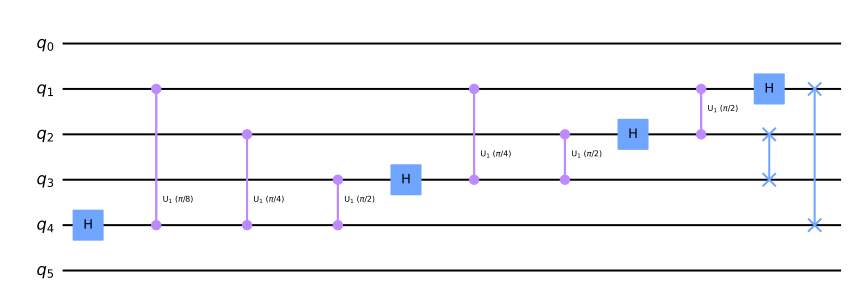

In [6]:
# Let's see how it looks for a circuit with 4 qubits (intial state |0000>):
qc = QuantumCircuit(6)
circ_=qc
position_initial=1
n_qubits=4
qft(circ_,position_initial,n_qubits)
#qc.measure_all()
qc.draw('mpl')

### 2. QFT inverse

Below, you will find two implementations of the QFT inverse or the QFT dagger. They are both equivalent even if the order of some quantum gates changes in the second one (done by Qiskit internally). Empirically we have seen that the first implementation (inverted circuit using Qiskit's inversion tool) is slightly faster.

#### 2.1 QFT dagger implementation using Qiskit's inversion tool

In [7]:
def inverse_qft(circuit: QuantumCircuit, position_initial: int=0, nombre_qubits: int=2, nombre_total_qubits: int=2):
    """Does the inverse QFT on the first n qubits ("nombre_qubits") in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(nombre_total_qubits), position_initial, nombre_qubits)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits (nombre_qubits) in our existing circuit
    circuit.append(invqft_circ, circuit.qubits)
    return circuit.decompose() # .decompose() allows us to see the individual gates


#### Example

C:\Users\leder\AppData\Local\Temp/ipykernel_14384/566104884.py:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  circuit.cu1(pi/2**(nombre_qubits-qubit), position_initial+qubit, position_initial+nombre_qubits)


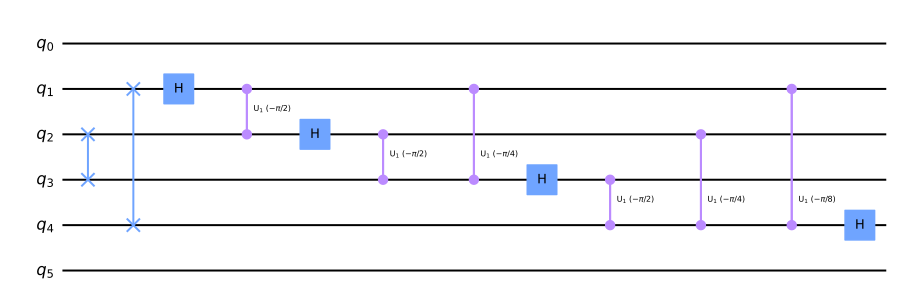

In [8]:
nqubits = 4
n_total_qubits = 6
position_initial=1
number = 5
qc = QuantumCircuit(n_total_qubits)

'''
for qubit in range(nqubits):
    qc.h(qubit)
    

qc.u1(number*pi/4,0)
qc.u1(number*pi/2,1)
qc.u1(number*pi,2)
'''

qc.draw('mpl')

qc = inverse_qft(qc,position_initial,nqubits,n_total_qubits)
#qc.measure_all()
qc.draw('mpl')



#### 2.2 QFT dagger implementation manually

In [9]:
def qft_dagger(circ_,position_initial,n_qubits):
    """n-qubit QFTdagger the first n qubits in circ"""
    for qubit in range(int(n_qubits/2)):
        circ_.swap(position_initial+qubit,position_initial+n_qubits-1-qubit)
    for j in range(0,n_qubits):
        for m in range(j):
            circ_.cp(-np.pi/float(2**(j-m)), position_initial+m, position_initial+j)
        circ_.h(position_initial+j)



#### Example

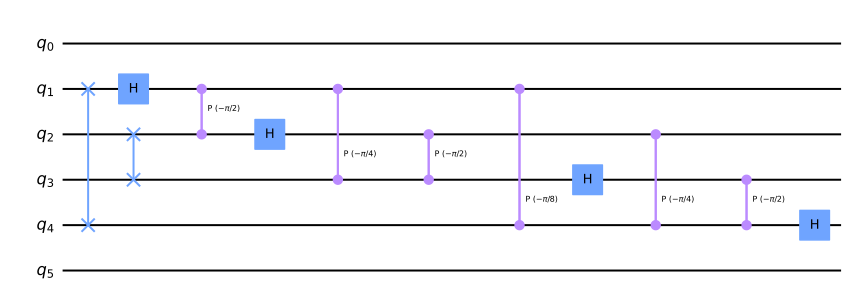

In [10]:
qc = QuantumCircuit(6)
qc.draw('mpl')

circ_=qc
position_initial=1
n_qubits=4
qft_dagger(circ_,position_initial,n_qubits)
#qc.measure_all()
qc.draw('mpl')

## 5. Quantum Phase Estimation (QPE) <a name="qpe"></a>

In this section, three functions are introduced. The first returns the controlled quantum gate associated to $U=e^{iAt}$, while the second and third are the implementations of QPE and QPE dagger, respectively.

### 5.1 QFT-based QPE Algorithm using pointers <a name="QFT_based_QPE_pointers"></a>

In [11]:
# a: clock register (HHL+) or phase register (rapport intermédiaire) or ancillae register (Qiskit textbook chapter 3.6)
# q: input register (HHL+, rapport intermédiaire)
# s: ancilla register (HHL+) or auxiliary register (rapport intermédiaire, Qiskit textbook Chapter 3.6)

# global variables to test the second call to the Hamiltonian Simulation module 
list_CU_operators = None 
exponent_r = None
flag_get_CU_gate = False # variable to modify list_CU_operators each repetition of HHL


def get_CU_gate(num_qubits_a: int=1,
                    num_qubits_q: int=1,
                    t: int=50,
                    unitary_matrix: Optional[List]=None,               # parameter to test the validity of the model
                    matrix: Optional[List]=None,
                    nonzero_entries: Optional[List]=None,
                    inverse_gate: bool=False):           

    
    global list_CU_operators, exponent_r, flag_get_CU_gate
    
    # if qpe_hhl has called this function
    if(list_CU_operators is None or flag_get_CU_gate == False):
    
        ## get the matrices U_1,...,U_n and and the scalar r so that U=(U1*...*Un)*...*(U1*...*Un): r times "(U1*...*Un)".
        if(matrix is not None and nonzero_entries is not None):
            list_U_matrices, exponent_r = hamiltonian_simulation([nonzero_entries, matrix],t)
            dim_U_matrix = len(matrix)
        elif(unitary_matrix is not None):
            list_U_matrices = [unitary_matrix]                 
            exponent_r = 1
            dim_U_matrix = len(unitary_matrix)
        else:
            print("list_U_operators cannot be properly implemented. Provide a matrix or a valid operator (or see the Hamiltonien Simulation module).")
    
    
        ## construct the operators controlled-(Uj) to be applied in reverse order of qiskit convention
        list_CU_operators = []
        for k in range(len(list_U_matrices)):
            matrix_CU = np.identity(dim_U_matrix*2, dtype = 'complex_')
            for i in range(dim_U_matrix):
                for j in range(dim_U_matrix):
                    matrix_CU[dim_U_matrix+i][dim_U_matrix+j] = list_U_matrices[k][i][j]
            operator_CU = Operator(matrix_CU)
            list_CU_operators.append(operator_CU)
        
        flag_get_CU_gate = True
    else:
        flag_get_CU_gate = False
    
    ## convert the unitary operators into a quantum gates controlled-(U1*...*Un) to be applied r times
    qc_temp = QuantumCircuit(1+num_qubits_q) 
    prefix_gate_name = "C-U"
    
    for i in range(len(list_CU_operators)):
        suffix_gate_name  = str(i)
        if(inverse_gate):
            suffix_gate_name += "^dagger"
        qc_temp.append(list_CU_operators[i].to_instruction().copy(prefix_gate_name+suffix_gate_name), 
                       [x for x in range(num_qubits_q,-1,-1)])   # the order of qubits is reversed taking into account the Qiskit convention of ordering qubits  
       
    ## deciding if returning the CU_gate or its inverse
    CU_gate = qc_temp.to_gate()
    if(inverse_gate == False):
        return CU_gate, exponent_r 
    else:
        CU_gate_inv = CU_gate.inverse()
        CU_gate_inv.name = "C-U^dagger"
        return CU_gate_inv, exponent_r 
    
    
def qpe_hhl(circuit, 
            pos_init_qreg_a: int, 
            num_qubits_a: int, 
            pos_init_qreg_q: int, 
            num_qubits_q: int=1,
            unitary_matrix: Optional[List]=None,             # parameter to test the validity of the model
            matrix: Optional[List]=None,
            nonzero_entries: Optional[List]=None,
            t: int=45,
            measurement: bool=False,
            Qiskit_reading_direction: bool=True):              
    
    
    ## apply the Hadamard gate
    for qubit in range(pos_init_qreg_a, pos_init_qreg_a+num_qubits_a):
        circuit.h(qubit)
    
    ## create the controlled-U operator and turn it into a gate
    
    if (unitary_matrix != None) : 
        CU_gate, exponent_r = get_CU_gate(num_qubits_a, num_qubits_q, t, unitary_matrix, matrix, nonzero_entries)
    else : 
        CU_gate, exponent_r = get_CU_gate(num_qubits_a, num_qubits_q, t,None, matrix, nonzero_entries)
        
    ## apply the controlled-U^{2^j} gates
    repetitions = 1
    for qubit_qreg_a in range(pos_init_qreg_a, pos_init_qreg_a+num_qubits_a):
        for i in range(repetitions):
        
        # apply the Controlled-U gate (or the approximation: C-U=C-((U1*...*Un)^r) to the main circuit
            qubits_control = [qubit_qreg_a]
            qubits_controlled = [x for x in range(pos_init_qreg_q, pos_init_qreg_q+num_qubits_q)]
            
            for j in range(exponent_r):
                circuit.append(CU_gate.copy("controlled-U"), qubits_control+qubits_controlled)    
        repetitions *= 2
    
    
    ## apply inverse QFT
    qft_dagger(circuit, pos_init_qreg_a, num_qubits_a)
    

    # swap the qubits in the quantum register "a" if demanded (Qiskit_reading_direction == False). 
    if(Qiskit_reading_direction == False):
        for qubit_qreg_a in range(pos_init_qreg_a, pos_init_qreg_a+num_qubits_a//2):
            circuit.swap(qubit_qreg_a, num_qubits_a-qubit_qreg_a-1)
    
    # add a measurement section at the end of the circuit if necessary (measurement == True). 
    if measurement:
        c_a = ClassicalRegister(num_qubits_a, name='ca')
        circuit.add_register(c_a)
        circuit.barrier()    # the safeguard-barrier
        for qubit_qreg_a in range(pos_init_qreg_a, pos_init_qreg_a+num_qubits_a):
            circuit.measure(qubit_qreg_a, c_a[qubit_qreg_a-pos_init_qreg_a])
            
    

def qpedagger_hhl(circuit, 
            pos_init_qreg_a: int, 
            num_qubits_a: int, 
            pos_init_qreg_q: int, 
            num_qubits_q: int=1,
            unitar_matrix: Optional[List]=None,
            matrix: Optional[List]=None,
            nonzero_entries: Optional[List]=None,
            t: int=45,
            measurement: bool=False,
            Qiskit_reading_direction: bool=True):            # parameter to test the validity of the model
    
    # swap the qubits in the quantum register "a" if demanded (Qiskit_reading_direction == False). 
    if(Qiskit_reading_direction == False):
        for qubit_qreg_a in range(pos_init_qreg_a, pos_init_qreg_a+num_qubits_a//2):
            circuit.swap(qubit_qreg_a, num_qubits_a-qubit_qreg_a-1)
    
    ## apply QFT
    qft(circuit, pos_init_qreg_a, num_qubits_a)
    
    
    ## create the controlled-U^dagger operator and turn it into a gate
    if (unitar_matrix != None) : 
        CU_gate, exponent_r = get_CU_gate(num_qubits_a, num_qubits_q, t, unitary_matrix, matrix, nonzero_entries, inverse_gate=True)
    else : 
        CU_gate, exponent_r = get_CU_gate(num_qubits_a, num_qubits_q, t,None, matrix, nonzero_entries, inverse_gate=True)
        
    ## apply the controlled-U^{2^j} gates
    repetitions = 2**(num_qubits_a-1)
    for qubit_qreg_a in range(pos_init_qreg_a+num_qubits_a-1, pos_init_qreg_a-1, -1):
        for i in range(repetitions):
        
        # apply the Controlled-U gate (or the approximation: C-U=C-((U1*...*Un)^r) to the main circuit
            qubits_control = [qubit_qreg_a]
            qubits_controlled = [x for x in range(pos_init_qreg_q, pos_init_qreg_q+num_qubits_q)]
            
            for j in range(exponent_r):
                circuit.append(CU_gate.copy("controlled-U^dagger"), qubits_control+qubits_controlled)    

        repetitions //= 2
        
    
    
    ## apply the Hadamard gate
    for qubit in range(pos_init_qreg_a, num_qubits_a):
        circuit.h(qubit)

    
    # add a measurement section at the end of the circuit if necessary (measurement == True). 
    if measurement:
        c_a = ClassicalRegister(num_qubits_a, name='ca')
        circuit.add_register(c_a)
        circuit.barrier()    # the safeguard-barrier
        for qubit_qreg_a in range(pos_init_qreg_a, pos_init_qreg_a+num_qubits_a):
            circuit.measure(qubit_qreg_a, c_a[qubit_qreg_a-pos_init_qreg_a])
            
    

### Exemple <a name="QFT_based_QPE_pointers_exemple"></a>

Dans ce premier exemmple, nous allons reprendre l'exemple introductif 
$$ \newcommand{\ket}[1]{\left|\,{#1}\right\rangle}
$$
Soit  $$A = \begin{pmatrix} 1 & -1/3 \\ -1/3 & 1 \end{pmatrix}$$

où $\ket {b} = \ket{u_1} = \ket{+} $

on choisit $t= 2\pi \cdot \frac {3}{8}$, on a alors 
$$
\theta_1 = \frac {\lambda_1 t}{2\pi } = 1/4
$$

en prenant donc $n_l = 2$, on a alors $\ket {\theta_1} = \ket {01}_{n_l}$


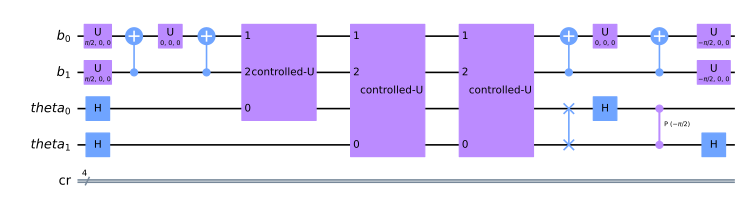

In [12]:
num_ancillae = 2          #n_l
num_state = 2             #n_b
t = 6*np.pi/8
qr_a = QuantumRegister(num_ancillae, name='theta')
qr_q = QuantumRegister(num_state, name='b')
c = ClassicalRegister(num_ancillae+num_state, name='cr')


# matrix A
#matrix = [[1, -1/3],
#          [-1/3, 1]]
matrix = [[1, -1/3,0,0],
          [-1/3, 1,0,0],
          [0,0,1, -1/3],
          [0,0,-1/3, 1]]

#nonzero_entries = [[0, 1],
 #                 [0, 1]]

nonzero_entries = [[0, 1, 2, 3],
                   [0, 1, 2, 3],
                   [0, 1, 2, 3],
                   [0, 1, 2, 3]]

initial_state = [1, 1, 1, 1]
#initial_state = [1, 1, 1, 1]

qc = QuantumCircuit(qr_q,qr_a,c)


# set the initial state using qiskit
state_in = Custom(num_qubits=num_state, state_vector = np.array(initial_state))
qc.data += state_in.construct_circuit('circuit', qr_q).data   #qc.data : Return the circuit data (instructions and context).


# call the modules hamiltonian simulation (classical) + QPE + QFT
qpe_hhl(circuit=qc, pos_init_qreg_a=2, num_qubits_a=num_ancillae, pos_init_qreg_q=0, num_qubits_q=2,
        matrix=matrix, nonzero_entries=nonzero_entries, t=t, measurement=False, Qiskit_reading_direction=True)
#qpedagger_hhl(circuit=qc, pos_init_qreg_a=0, num_qubits_a=num_ancillae, pos_init_qreg_q=num_ancillae, unitar_matrix=None, matrix=matrix, nonzero_entries=nonzero_entries, t=t, measurement=False, Qiskit_reading_direction=True)
qc.data += state_in.construct_circuit('circuit', qr_q).inverse().data
qc.draw(scale=0.8) #use "qc.decompose().draw(scale=0.8)" to see all the black-boxes (decomposed in the set of universal gates of Open-QASM: {u1, u2, u3, CNOT})

Ainsi après QPE, le résultat attendue est : 

$$ \ket{01}_{n_l}\ket {+} = \frac{1}{\sqrt{2}} \left(\ket{01}_{n_l}\ket{0}_{n_b} + \ket{01}_{n_l}\ket{1}_{n_b}\right) $$

on s'attend donc à avoir équiprobabilité de mesurer "$100$" et "$101$" à la sortie de l'algorithme.

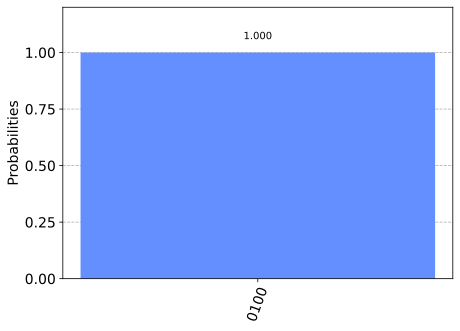

In [13]:
for i in range(num_ancillae+num_state):
    qc.measure(i,i)

backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

## 6. Inversion des valeurs propres <a name="inveigenvals"></a>

### 1. Module arithmétique<a name="arithmetic"></a>

In [14]:
###########
####QFT####
###########

def qca_qft(qc,r):
    #Adds QFT operations on circuit qc, on the register indexed by r
    #cf. Qiskit textbook, 3.5, for explanation of the algorithm
    n=len(r)
    for i in range(n):
        qc.h(r[n-1-i])
        for j in range(n-i-1):
            qc.cp(pi/2**(n-1-i-j),r[j],r[n-1-i])
    for i in range(n//2):
        qc.swap(r[i],r[n-1-i])
        
def qca_qftdagger(qc,r):
    #Adds QFTdagger operations on circuit qc, on the register indexed by r
    n=len(r)
    for i in range(n//2):
        qc.swap(r[i],r[n-1-i])
    for i in reversed(range(n)):
        for j in reversed(range(n-i-1)):
            qc.cp(-pi/2**(n-1-i-j),r[j],r[n-1-i])
        qc.h(r[n-1-i])
        
def qca_c_qft(qc,r,pos_ctrl):
    #Does the same thing as qca_qft, but with all the gates controlled by qubit in position qctrl
    n=len(r)
    for i in range(n):
        qc.ch(pos_ctrl,r[n-1-i])
        for j in range(n-i-1):
            qc.mcp(pi/2**(n-1-i-j),[pos_ctrl,r[j]],r[n-1-i])
    for i in range(n//2):
        qc.cswap(pos_ctrl,r[i],r[n-1-i])
        
def qca_c_qftdagger(qc,r,pos_ctrl):
    #Does the same thing as qca_qftdagger, but with all the gates controlled by qubit in position qctrl
    n=len(r)
    for i in range(n//2):
        qc.cswap(pos_ctrl,r[i],r[n-1-i])
    for i in reversed(range(n)):
        for j in reversed(range(n-i-1)):
            qc.mcp(-pi/2**(n-1-i-j),[pos_ctrl,r[j]],r[n-1-i])
        qc.ch(pos_ctrl,r[n-1-i])
        
################
##Arithmétique##
################


#Addition
#########

def qca_adder(qc,a,b):
    #Input:
        #n+1 qubits of register indexed by a : (binary represantion in the computational basis of) a and |0\rangle on the last qubit
        #n+1 qubits of register indexed by b : |b\rangle on the first n qubits, |0\rangle on the last qubit (last qubit used to store last carry)
    #Output:
        #n qubits of register indexed by a : |a\rangle
        #n+1 qubits of register indexed by b : |a+b\rangle
    n=len(a)-1
    qca_qft(qc,b)
    qc.barrier()
    for i in range(n+1,0,-1):
        for j in range(i,0,-1):
            if j<=n:
                qc.cp(pi/2**(i-j),a[j-1],b[n+1-i])
    qc.barrier()
    qca_qftdagger(qc,b)

def qca_ccp(qc,theta,ctrl1,ctrl2,target):
    #Double controlled phase gate
    qc.cp(theta/2,ctrl2,target)
    qc.cx(ctrl1,ctrl2)
    qc.cp(-theta/2,ctrl2,target)
    qc.cx(ctrl1,ctrl2)
    qc.cp(theta/2,ctrl1,target)
    
def qca_c_adder(qc,a,b,pos_ctrl):
    #ctrl version of qca_adder
    n=len(a)-1
    qca_c_qft(qc,b,pos_ctrl)
    qc.barrier()
    for i in range(n+1,0,-1):
        for j in range(i,0,-1):
            if j<=n:
                qca_ccp(qc,pi/2**(i-j),pos_ctrl,a[j-1],b[n+1-i])
    qc.barrier()
    qca_c_qftdagger(qc,b,pos_ctrl)
    
#Pseudo-soustraction
####################

def qca_subber(qc,a,b):
    #Input:
        #n+1 qubits of register indexed by a : (binary represantion in the computational basis of) a and |0\rangle on the last qubit
        #n+1 qubits of register indexed by b : |b\rangle on the first n qubits, |0\rangle on the last qubit (last qubit used to store last carry)
    #Output:
        #n qubits of register indexed by a : |a\rangle
        #n+1 qubits of register indexed by b : |a-b\rangle
    n=len(a)-1
    qca_qft(qc,b)
    qc.barrier()
    for i in range(n+1,0,-1):
        for j in range(i,0,-1):
            if j<=n:
                qc.cp(-pi/2**(i-j),a[j-1],b[n+1-i])
    qc.barrier()
    qca_qftdagger(qc,b)
    
def qca_subber_swap(qc,a,b):
    #Input:
        #n+1 qubits of register indexed by a : (binary represantion in the computational basis of) a and |0\rangle on the last qubit
        #n+1 qubits of register indexed by b : |b\rangle on the first n qubits, |0\rangle on the last qubit (last qubit used to store last carry)
    #Output:
        #n qubits of register indexed by a : |a-b\rangle
        #n+1 qubits of register indexed by b : |b\rangle
    n=len(a)-1
    qca_qft(qc,a)
    qc.barrier()
    for i in range(n+1,0,-1):
        for j in range(i,0,-1):
            if j<=n:
                qc.cp(-pi/2**(i-j),b[j-1],a[n+1-i])
    qc.barrier()
    qca_qftdagger(qc,a)
    
#Division
#########

def qca_ls(qc,a,n):
    #left shifts register indexed by a n times.
    if(n==1):
        for i in range(len(a)-1):
            qc.swap(a[len(a)-1-i],a[len(a)-2-i])
    elif(n>1):
        for i in range(len(a)-1):
            qc.swap(a[len(a)-1-i],a[len(a)-2-i])
        qca_ls(qc,a,n-1)

def listrs(L):
    #Returns list obtained by right-shifting 1 time L
    return([L[-1]]+L[:-1])

def listls(L):
    #Returns list obtained by left-shifting 1 time L
    return(L[1:]+[L[0]])
        
def qca_divider_V2(qc,p,d,q):
    n=len(q)
    for i in range(n-1,-1,-1):
        # Multipliying |p\rangle by 2 : is equivalent to shifting it to the left by one unit
        qca_ls(qc,p,1)
        # Subtracting |d\rangle to |p\rangle, forcing rightmost qubit to be the subbing pad
        qca_subber_swap(qc,listls(p),listls(d))
        # If the result is positive, indicated by |p\rangle rightmost qubit being |0\rangle, then the i-th bit of the quotient is 1
        qc.x(p[0])
        qc.cx(p[0],q[i])
        qc.x(p[0])
        # Else, the result is negative and we add back |d\rangle to |p\rangle
        # This operation is controlled by the fact that the i-th qubit of the quotient is still |0\rangle
        qc.x(q[i])
        qca_c_adder(qc,listls(d),listls(p),q[i])
        qc.x(q[i])

def div(qc,p,d,q,n):
    qca_divider_V2(qc,p,d,q)

### 2. Rotation <a name="rotation"></a>

Cette partie contient une implémentation de l'opérateur suivant : 

$$
U_\theta\ket{\theta}\ket{0} =  \ket{\theta} (\cos \theta\ket{0}+  \sin \theta\ket{1})
$$

il s'agit donc d'une rotation sur le second registre contrôlée par le premier. 
Pour lever toute ambigüité, rappelons que $\ket{\theta}$ contient une approximation binaire de la phase réel $\theta\in [0,1[$, ce qui signifie en pratique que $\theta\in \{0, \frac{1}{2^n}, \cdots, \frac{2^n-1}{2^n} \}$ où $n$ est la taille du registre de contrôle.

In [15]:
def qc_rotation (qc, n, control_qubit, target_qubit): 
    # qc : object quantum circuit 
    # n : number of qubits on which we control our rotation 
    # control_qubit : first position of controlled qubits
    # target_qubit : position of target qubit
    for i in range (n) : 
        qc.ry(1/2**(i+1), target_qubit)
        qc.cx(n+control_qubit-i-1 , target_qubit)
        qc.ry(-1/2**(i+1), target_qubit)
        qc.cx(n+control_qubit-i-1, target_qubit)
        
# for specific reasons, we would like to divide the controlled register in two parts 
# this is motivated by the fact that our implementation of division gives a quotient and rest
# and concerned qubits are located in two different regiters

def qc_rotation_bis (qc, n, control_qubit_1, control_qubit_2, target_qubit):
    # qc : object quantum circuit 
    # n : number of qubits divided by two on which we control our rotation 
    # control_qubit_1 : first position of first register of controlled qubits
    # control_qubit_2 : first position of second register of controlled qubits
    # target_qubit : position of target qubit
    for i in range (n) : 
        qc.ry(1/2**(i+1), target_qubit)
        qc.cx(n+control_qubit_1-i-1 , target_qubit)
        qc.ry(-1/2**(i+1), target_qubit)
        qc.cx(n+control_qubit_1-i-1, target_qubit)
    for i in range (n) : 
        qc.ry(1/2**(n+i+1), target_qubit)
        qc.cx(n+control_qubit_2-i-1 , target_qubit)
        qc.ry(-1/2**(n+i+1), target_qubit)
        qc.cx(n+control_qubit_2-i-1, target_qubit) 

### Exemple <a name="rotation_ex"></a>

En guise d'exemple, regardons le circuit d'une rotation contrôlée par 3 qubits et où $\ket{\theta} = \ket {111}$

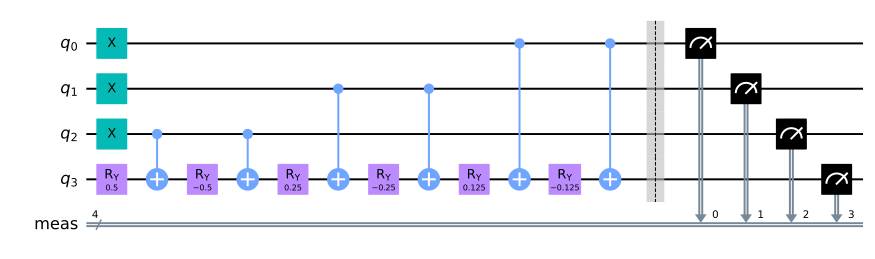

In [16]:
qc = QuantumCircuit (4)
# init theta = |111>
qc.x(0) 
qc.x(1)
qc.x(2)
#qc.barrier()
qc_rotation (qc, 3, 0, 3)
qc.measure_all()
qc.draw()

On s'attend donc que le dernier registre soit égal à $\cos (\frac{7}{8})\ket{0} + \sin (\frac{7}{8})\ket{1}$. On a donc une probabilité de $\cos (\frac{7}{8})^2 \approx 0,410$ de mesurer le dernier qubit dans l'état $\ket{0}$ et de approximativement $0,589$ de le mesurer dans l'état $1$.

(Remarque, ici les trois premiers qubits sont les qubits de contrôle et le dernier et le qubit cible)

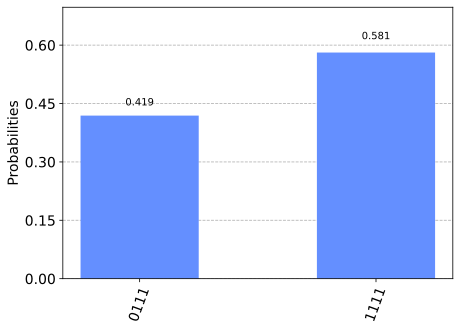

In [17]:
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

## 7. Algorithme HHL <a name="launch"></a>

Comme mentionné précédemment, dans notre implémentation de l'algorithme HHL, le registre auxiliaire $S$ contient en réalité $4n_l+1$ qubits, plus précisemment 4 registres tous de taille $n_l$ et un registre de taille 1:

- un registre auxiliaire $aux$ interne à l'algorithme de division ; 
- un registre $r$ contenant le reste de la division de $C$ par $\theta$ ;
- un registre $d$ contenant $C$  ;
- un registre $q$ contenant $C/\theta$ ; 
- un registre $S$ sur lequel on applique la rotation contrôlée. 

Ainsi, cette implémentation de l'algorithme HHL reçoit en entrée des qubits de la forme : 

$$\ket{0\cdots0}_{n_l}\ket{0\cdots0}_{n_b}\ket{0\cdots0}_{aux}\ket{0\cdots0}_{r}\ket{0\cdots0}_{d}\ket{0\cdots0}_{q}\ket{0}_{S}$$

In [18]:
def HHL (num_ancille, num_state, t, matrix, initial_state, C=0) : 
    print(t)
    # num_ancillae is the number of qubits used in QPE for phase estimation (n_l)
    # num_state is the number of qubits used for |b> (n_b)
    # matrix is the matrix of the system
    # initial state is the value of vector b 
    # C parameter, if set 0 then C=|11...1> (biggest value possible but not a good ida, see remark)

        
    # 5*num_ancillae + num_state + 1 
    
    qr_theta = QuantumRegister(num_ancillae, name='theta')
    qr_b = QuantumRegister(num_state, name='b')
    qr_aux = QuantumRegister(num_ancillae, name='aux')
    qr_r = QuantumRegister(num_ancillae, name='r')
    qr_d = QuantumRegister(num_ancillae, name='d')
    qr_q = QuantumRegister(num_ancillae, name='q')
    qr_S = QuantumRegister(1, name='s')

    qc = QuantumCircuit (qr_theta, qr_b, qr_aux, qr_r, qr_d, qr_q, qr_S)


    # set the initial state using qiskit

    state_in = Custom(num_qubits=num_state, state_vector = np.array(initial_state))
    qc = qc.compose (state_in.construct_circuit('circuit', qr_b), [2])   #qc.data : Return the circuit data (instructions and context).

    # call the modules hamiltonian simulation (classical) + QPE + QFT
    global list_CU_operators, exponent_r, flag_get_CU_gate
    list_CU_operators = None
    exponent_r = None
    flag_get_CU_gate = None
    qpe_hhl(circuit=qc, pos_init_qreg_a=0, num_qubits_a=num_ancillae, pos_init_qreg_q=num_ancillae, unitary_matrix=None, matrix=matrix, t=t, measurement=False, Qiskit_reading_direction=True, nonzero_entries=nonzero_entries)

    qc.barrier()

    # call eigenvalue rotation 

    # step 1 : ASNINV

    for i in range (num_ancillae) : 
        qc.x(num_state+3*num_ancillae+i)

    #qc.x(num_state+4*num_ancillae-1)


    # Divider that takes |p>|d>|q>.
    # |p> is length 2n and has n zeros on the left: 0 ... 0 p_n ... p_1.
    # |d> has length 2n and has n zeros on the right: d_2n ... d_{n+1) 0 ... 0.
    # |q> has length n and is initially all zeros.
    # At the end of the algorithm, |q> will contain the quotient of p/d, and the
    # left n qubits of |p> will contain the remainder of p/d.

    #Qiskit order of qubits may be a little be confusing since qubits order are inverted meaning  
    # 0 ... 0 p_n ... p_1 will appear as |p_1 ... p_n 0 ... 0> 
    #

    p_idx = list (range(num_state+3*num_ancillae, num_state+4*num_ancillae)) + list (range(num_state+2*num_ancillae, num_state+3*num_ancillae))
    print("p_idx: ",p_idx)
    d_idx = list(range(num_state+num_ancillae,num_state+2*num_ancillae)) + list (range(num_ancillae))
    print("d_idx: ",d_idx)
    q_idx = list (range (num_state+4*num_ancillae, num_state+5*num_ancillae))
    print("q_idx: ",q_idx)
    
    div (qc=qc, 
         p=p_idx, 
         d=d_idx,
         q=q_idx, 
         n=num_ancillae)


    qc.barrier()


    # step 2 : controlled rotaiotn 

    qc_rotation_bis (qc, num_ancillae,  num_state+4*num_ancillae, num_state+2*num_ancillae,num_state+5*num_ancillae)

    qc.barrier()

    # step 3 : ASNINV_dagger

    qc_aux = QuantumCircuit (5*num_ancillae + num_state)

    div (qc_aux, list (range(num_state+3*num_ancillae, num_state+4*num_ancillae)) + list (range(num_state+2*num_ancillae, num_state+3*num_ancillae)), 
             list(range(num_state+num_ancillae,num_state+2*num_ancillae)) + list (range(num_ancillae)),
             list (range (num_state+4*num_ancillae, num_state+5*num_ancillae)), num_ancillae)

    qc = qc.compose (qc_aux.inverse(), list(range(num_state+ 5*num_ancillae)))

    for i in range (num_ancillae) : 
        qc.x(num_state+3*num_ancillae+i)

    #qc.x(num_state+4*num_ancillae-1)

    qc.barrier()

    # QPE dagger 

    qpedagger_hhl(circuit=qc, pos_init_qreg_a=0, num_qubits_a=num_ancillae, pos_init_qreg_q=num_ancillae, unitar_matrix=None, matrix=matrix, t=t, measurement=False, Qiskit_reading_direction=True, nonzero_entries=nonzero_entries)

    qc.barrier()
    #qc.draw(filename="nouveau")
    qc.measure_all()
    
    return qc



def liste_state (n_b, n_l) : 
    
    def liste_ket (n_b) : 
        if (n_b == 1) : 
            return ['0', '1']
        else : 
            L = liste_ket (n_b-1)
            res = []
            for x in L : 
                res.append (x+'1')
                res.append (x+'0')
            return res
        
    L = liste_ket (n_b)
    res = []
    for x in L : 
        res.append ((x,'1'+'0'*(4*n_l)+x+ '0'*n_l))
    return res
    
def analysis (num_state, num_ancillae, answer) : 
    nombre_1 = 0 
    nombre_tot = 0
    for cle, valeur in answer.items():
        nombre_tot += valeur
        if (str(cle)[0] == '1') : 
            nombre_1 += valeur
            
    print ("la probabilité de réussite de l'algorithme est d'environ", nombre_1*1.0/nombre_tot*100, "% de chance") 
    
    for x,y in liste_state (num_state, num_ancillae) :
        try:
            print ("la probabilité de mesurer l'état |"+ x +">", "est", answer[y]*1.0/nombre_1)
        except:
            pass

### Exemple  1

Reprenons l'exemple 1 donné plus haut : 

2.356194490192345
p_idx:  [7, 8, 5, 6]
d_idx:  [3, 4, 0, 1]
q_idx:  [9, 10]


C:\Users\leder\AppData\Local\Temp/ipykernel_14384/566104884.py:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  circuit.cu1(pi/2**(nombre_qubits-qubit), position_initial+qubit, position_initial+nombre_qubits)


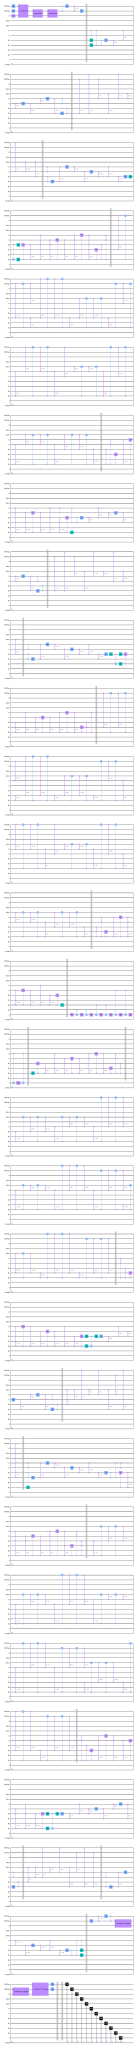

In [19]:
num_ancillae =   2       # n_l
num_state = 1            # n_b
t = 6*np.pi/8
matrix = [[1, -1/3],
          [-1/3, 1]]
initial_state = [1, 1]

qc = HHL (num_ancillae, num_state, t, matrix, initial_state)

# pour visualiser le circuit 
qc.draw (scale=0.55)

Le résultat est le suivant :

la probabilité de réussite de l'algorithme est d'environ 65.0634765625 % de chance
la probabilité de mesurer l'état |0> est 0.499437148217636
la probabilité de mesurer l'état |1> est 0.5005628517823639


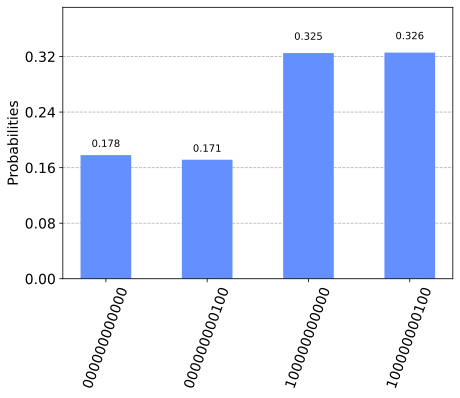

In [20]:
backend = Aer.get_backend('qasm_simulator')
shots = 2048*10
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()

# calcul de la probabilité estimée de réussite de l'algorithme

analysis (num_state, num_ancillae, answer)

plot_histogram(answer)

### Exemple  2

Reprenons l'exemple 2 donné plus haut : 

In [21]:
num_ancillae =   2       # n_l
num_state = 1            # n_b
t = 6*np.pi/8          # t
matrix = [[1, -1/3],
          [-1/3, 1]]
initial_state = [1, 0]

qc = HHL (num_ancillae, num_state, t, matrix, initial_state)

# pour visualiser le circuit 
# qc.draw (scale=0.55)

2.356194490192345
p_idx:  [7, 8, 5, 6]
d_idx:  [3, 4, 0, 1]
q_idx:  [9, 10]


C:\Users\leder\AppData\Local\Temp/ipykernel_14384/566104884.py:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  circuit.cu1(pi/2**(nombre_qubits-qubit), position_initial+qubit, position_initial+nombre_qubits)


Le résultat est le suivant :

la probabilité de réussite de l'algorithme est d'environ 65.0146484375 % de chance
la probabilité de mesurer l'état |0> est 1.0


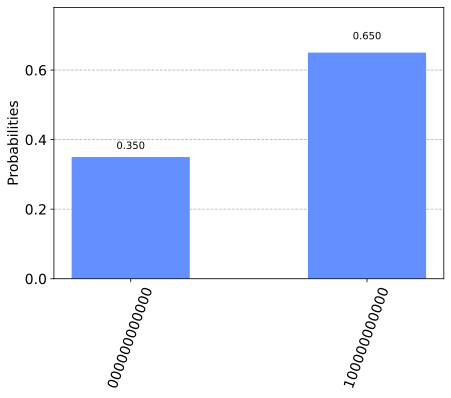

In [22]:
backend = Aer.get_backend('qasm_simulator')
shots = 2048*10
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()

# calcul de la probabilité estimée de réussite de l'algorithme

analysis (num_state, num_ancillae, answer)

plot_histogram(answer)